<a href="https://colab.research.google.com/github/restful3/ds4th_study/blob/main/wooseok_code/Chest_X_Ray_%EC%82%AC%EC%A7%84%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 준비

In [7]:
# https://soohee410.github.io/colab_kaggle 에서 설정방법에 따라 데이터셋을 구글드라이브에 다운 받고 아래의 환경설정으로 따라 하세요 
# 파일 - 사본으로 저장하기로 복사하세요
import os

os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/SelfStudy/캐글스터디/'
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
data_path = '/content/drive/MyDrive/SelfStudy/캐글스터디/chest_xray/'
train_path = data_path + 'train/'
valid_path = data_path + 'val/'
test_path = data_path + 'test/'

In [13]:
from glob import glob

print(f'훈련 데이터 개수 : {len(glob(train_path + "*/*"))}')
print(f'검증 데이터 개수 : {len(glob(valid_path + "*/*"))}')
print(f'테스트 데이터 개수 : {len(glob(test_path + "*/*"))}')


훈련 데이터 개수 : 5216
검증 데이터 개수 : 16
테스트 데이터 개수 : 624


In [14]:
all_normal_imgs = []    # 모든 정상 이미지를 담을 리스트 초기화
all_pneumonia_imgs = [] # 모든 폐렴 이미지를 담을 리스트 초기화

for cat in ['train/', 'val/', 'test/']:
    data_cat_path = data_path + cat
    # 정상, 폐렴 이미지 경로
    normal_imgs = glob(data_cat_path + 'NORMAL/*')
    pneumonia_imgs = glob(data_cat_path + 'PNEUMONIA/*')
    # 정상, 폐렴 이미지 경로를 리스트에 추가
    all_normal_imgs.extend(normal_imgs)
    all_pneumonia_imgs.extend(pneumonia_imgs)

print(f'정상 흉부 이미지 개수 : {len(all_normal_imgs)}')
print(f'폐렴 흉부 이미지 개수 : {len(all_pneumonia_imgs)}')

정상 흉부 이미지 개수 : 1583
폐렴 흉부 이미지 개수 : 4273


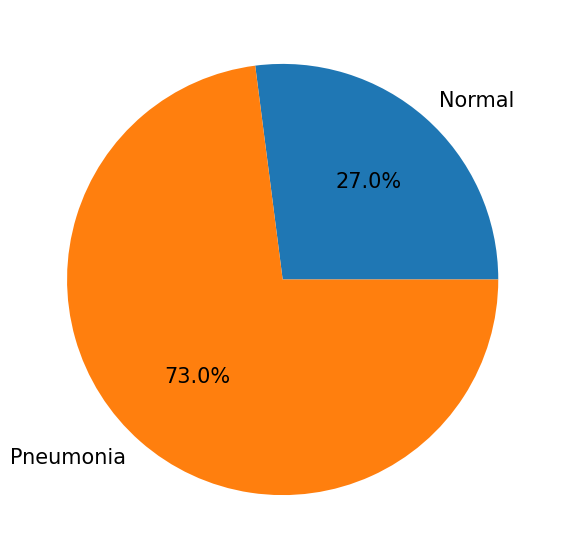

In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

label = ['Normal', 'Pneumonia'] # 타깃값 레이블
# 타깃값 분포 파이 그래프
plt.pie([len(all_normal_imgs), len(all_pneumonia_imgs)], 
        labels=label, 
        autopct='%.1f%%');

In [16]:
import matplotlib.gridspec as gridspec
import cv2

def show_image(img_paths, rows=2, cols=3): 
    assert len(img_paths) <= rows*cols # 이미지가 행/열 개수보다 많으면 오류 발생
    
    mpl.rc('font', size=8)
    plt.figure(figsize=(15, 8)) 
    grid = gridspec.GridSpec(rows, cols) # 서브플롯 배치

    # 이미지 출력
    for idx, img_path in enumerate(img_paths):
        image = cv2.imread(img_path) # 이미지 파일 읽기
        ax = plt.subplot(grid[idx])
        ax.imshow(image) # 이미지 출력

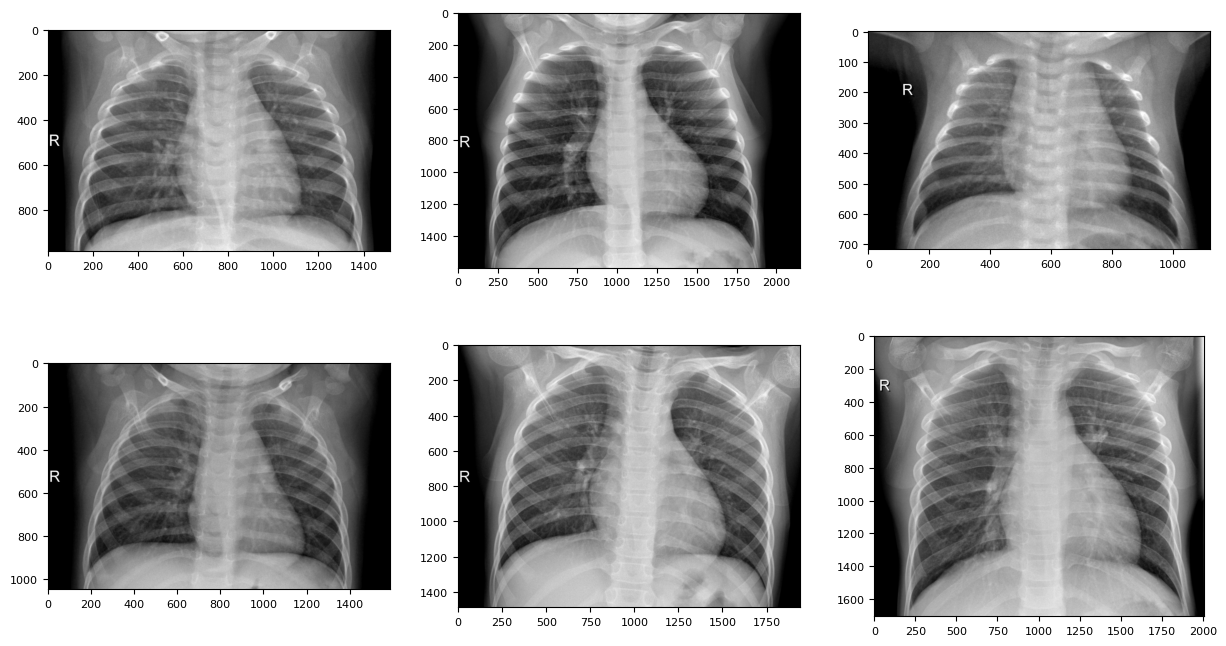

In [17]:
# 정상 엑스선 이미지 경로(마지막 6장)
num_of_imgs = 6
normal_img_paths = all_normal_imgs[-num_of_imgs:]

# 이미지 출력
show_image(normal_img_paths)

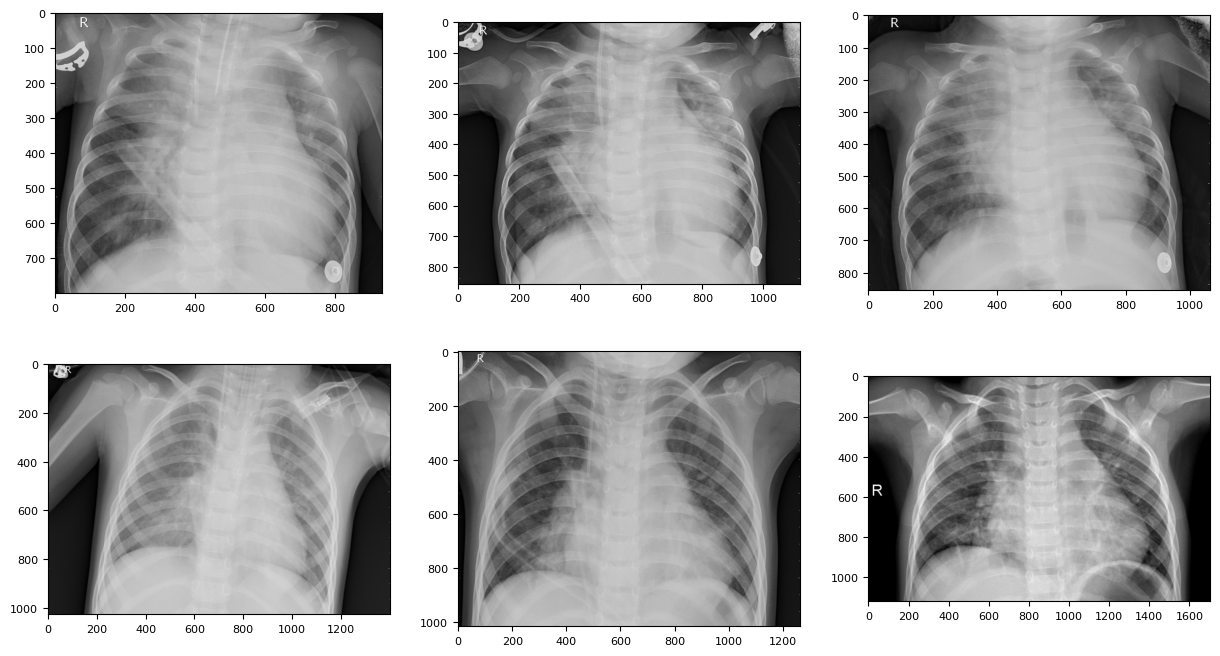

In [18]:
# 폐렴 엑스선 이미지 경로(마지막 6장)
pneumonia_img_paths = all_pneumonia_imgs[-num_of_imgs:]

# 이미지 출력
show_image(pneumonia_img_paths)

In [19]:
from torchvision import transforms

# 훈련 데이터용 변환기
transform_train = transforms.Compose([
                          transforms.Resize((250, 250)),      # 이미지 크기 조정 
                          transforms.CenterCrop(180),         # 중앙 이미지 확대
                          transforms.RandomHorizontalFlip(0.5), # 좌우 대칭
                          transforms.RandomVerticalFlip(0.2), # 상하 대칭
                          transforms.RandomRotation(20),      # 이미지 회전
                          transforms.ToTensor(),              # 텐서 객체로 변환
                          transforms.Normalize((0.485, 0.456, 0.406), 
                                               (0.229, 0.224, 0.225))]) # 정규화

# 테스트 데이터용 변환기
transform_test = transforms.Compose([
                          transforms.Resize((250, 250)),
                          transforms.CenterCrop(180),
                          transforms.ToTensor(),
                          transforms.Normalize((0.485, 0.456, 0.406), 
                                               (0.229, 0.224, 0.225))])

In [20]:
from torchvision.datasets import ImageFolder

# 훈련 데이터셋
datasets_train = ImageFolder(root=train_path, transform=transform_train)
# 검증 데이터셋
datasets_valid = ImageFolder(root=valid_path, transform=transform_test)

In [21]:
import torch  
import random
import numpy as np
import os

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# 제너레이터 시드값 고정
g = torch.Generator()
g.manual_seed(0)

In [22]:
from torch.utils.data import DataLoader

batch_size = 8

loader_train = DataLoader(dataset=datasets_train, batch_size=batch_size, 
                          shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)
loader_valid = DataLoader(dataset=datasets_valid, batch_size=batch_size, 
                          shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

In [23]:
!pip install efficientnet-pytorch==0.7.1 -d ''

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=0071e32d8e0eba8e052072d1f76120115b7efc36a81c3b6230f63b4e26e9675c
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
Successfully built efficientnet-pytorch


In [24]:
from efficientnet_pytorch import EfficientNet
# 모델 생성
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2) 
# 장비 할당
model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 151MB/s]


Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


In [26]:
print('모델 파라미터 개수 :', sum(param.numel() for param in model.parameters()))

모델 파라미터 개수 : 4010110


In [27]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [28]:
from sklearn.metrics import accuracy_score # 정확도 계산 함수
from sklearn.metrics import recall_score   # 재현율 계산 함수
from sklearn.metrics import f1_score       # F1 점수 계산 함수
from tqdm.notebook import tqdm             # 진행률 표시 막대

def train(model, loader_train, loader_valid, criterion, optimizer, 
          scheduler=None, epochs=10, save_file='model_state_dict.pth'):
    
    valid_loss_min = np.inf # 최소 손실값 초기화 (검증 데이터용) 

    # 총 에폭만큼 반복
    for epoch in range(epochs):
        print(f'에폭 [{epoch+1}/{epochs}] \n-----------------------------')
        
        # == [ 훈련 ] ==============================================
        model.train()        # 모델을 훈련 상태로 설정
        epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
        # '반복 횟수'만큼 반복 
        for images, labels in tqdm(loader_train):
            # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
            images = images.to(device)
            labels = labels.to(device)
            
            # 옵티마이저 내 기울기 초기화
            optimizer.zero_grad()
            # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
            outputs = model(images)
            # 손실 함수를 활용해 outputs와 labels의 손실값 계산
            loss = criterion(outputs, labels)
            # 현재 배치에서의 손실 추가 (훈련 데이터용)
            epoch_train_loss += loss.item() 
            loss.backward()       # 역전파 수행
            optimizer.step()      # 가중치 갱신
            if scheduler != None: # 스케줄러 학습률 갱신 
                scheduler.step() 

        # 훈련 데이터 손실값 출력
        print(f'\t훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
        
        # == [ 검증 ] ==============================================
        model.eval()         # 모델을 평가 상태로 설정 
        epoch_valid_loss = 0 # 에폭별 손실값 초기화 (검증 데이터용)
        preds_list = []      # 예측값 저장용 리스트 초기화
        true_list = []       # 실젯값 저장용 리스트 초기화
        
        with torch.no_grad(): # 기울기 계산 비활성화
            for images, labels in loader_valid:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_valid_loss += loss.item()
                
                # 예측값 및 실제값 
                preds = torch.max(outputs.cpu(), dim=1)[1].numpy() 
                true = labels.cpu().numpy() 
    
                preds_list.extend(preds)
                true_list.extend(true)
                
        # 정확도, 재현율, F1 점수 계산
        val_accuracy = accuracy_score(true_list, preds_list)
        val_recall = recall_score(true_list, preds_list)
        val_f1_score = f1_score(true_list, preds_list)

        # 검증 데이터 손실값 및 정확도, 재현율, F1점수 출력
        print(f'\t검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f}')
        print(f'\t정확도 : {val_accuracy:.4f} / 재현율 : {val_recall:.4f} / F1 점수 : {val_f1_score:.4f}')
        # == [ 최적 모델 가중치 찾기 ] ==============================
        # 현 에폭에서의 손실값이 최소 손실값 이하면 모델 가중치 저장 
        if epoch_valid_loss <= valid_loss_min: 
            print(f'\t### 검증 데이터 손실값 감소 ({valid_loss_min:.4f} --> {epoch_valid_loss:.4f}). 모델 저장')
            # 모델 가중치를 파일로 저장 
            torch.save(model.state_dict(), save_file) 
            valid_loss_min = epoch_valid_loss # 최소 손실값 갱신 
    return torch.load(save_file) # 저장한 모델 가중치를 불러와 반환

In [29]:
# 모델 훈련
model_state_dict = train(model=model,
                         loader_train=loader_train, 
                         loader_valid=loader_valid,
                         criterion=criterion, 
                         optimizer=optimizer)

에폭 [1/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.4128
	검증 데이터 손실값 : 1.4479
	정확도 : 0.6875 / 재현율 : 1.0000 / F1 점수 : 0.7619
	### 검증 데이터 손실값 감소 (inf --> 2.8957). 모델 저장
에폭 [2/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2702
	검증 데이터 손실값 : 3.6898
	정확도 : 0.6250 / 재현율 : 1.0000 / F1 점수 : 0.7273
에폭 [3/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2490
	검증 데이터 손실값 : 0.6977
	정확도 : 0.7500 / 재현율 : 1.0000 / F1 점수 : 0.8000
	### 검증 데이터 손실값 감소 (2.8957 --> 1.3954). 모델 저장
에폭 [4/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2170
	검증 데이터 손실값 : 1.4025
	정확도 : 0.5000 / 재현율 : 0.1250 / F1 점수 : 0.2000
에폭 [5/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1964
	검증 데이터 손실값 : 0.8189
	정확도 : 0.6875 / 재현율 : 1.0000 / F1 점수 : 0.7619
에폭 [6/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1881
	검증 데이터 손실값 : 0.4516
	정확도 : 0.8750 / 재현율 : 0.7500 / F1 점수 : 0.8571
	### 검증 데이터 손실값 감소 (1.3954 --> 0.9033). 모델 저장
에폭 [7/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1722
	검증 데이터 손실값 : 0.6753
	정확도 : 0.6875 / 재현율 : 0.8750 / F1 점수 : 0.7368
에폭 [8/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1808
	검증 데이터 손실값 : 1.7680
	정확도 : 0.5625 / 재현율 : 1.0000 / F1 점수 : 0.6957
에폭 [9/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1583
	검증 데이터 손실값 : 0.3246
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
	### 검증 데이터 손실값 감소 (0.9033 --> 0.6493). 모델 저장
에폭 [10/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1642
	검증 데이터 손실값 : 0.8309
	정확도 : 0.6875 / 재현율 : 1.0000 / F1 점수 : 0.7619


In [31]:
# 최적 가중치 불러오기
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [30]:
datasets_test = ImageFolder(root=test_path, transform=transform_test)

loader_test = DataLoader(dataset=datasets_test, batch_size=batch_size, 
                         shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

In [32]:
def predict(model, loader_test, return_true=False):
    model.eval()    # 모델을 평가 상태로 설정
    preds_list = [] # 예측값 저장용 리스트 초기화
    true_list = []  # 실제값 저장용 리스트 초기화

    with torch.no_grad(): # 기울기 계산 비활성
        for images, labels in loader_test:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            
            preds = torch.max(outputs.cpu(), dim=1)[1].numpy() # 예측값
            true = labels.cpu().numpy() # 실제값 

            preds_list.extend(preds)
            true_list.extend(true)

    if return_true:
        return true_list, preds_list
    else:
        return preds_list


In [33]:
true_list, preds_list = predict(model=model, 
                                loader_test=loader_test, 
                                return_true=True)

In [34]:
print('#'*5, '최종 예측 결과 평가 점수', '#'*5)
print(f'정확도 : {accuracy_score(true_list, preds_list):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list):.4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list):.4f}')

##### 최종 예측 결과 평가 점수 #####
정확도 : 0.8429
재현율 : 0.8590
F1 점수 : 0.8724


# 준비과정 정리

In [ ]:
## /content/drive/MyDrive/SelfStudy/캐글스터디/ 를  관리할 폴더로 가정하여 작성햇습니다.

# from google.colab import drive
# drive.mount('/content/drive') # 드라이브 장착합니다.

# from google.colab import files
# files.upload()  # kaggle.json을 업로드 합니다.

# !cp /content/kaggle.json /content/drive/MyDrive/SelfStudy/캐글스터디/ # 키 이동

# import os
# os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/SelfStudy/캐글스터디/'


# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# !unzip /content/chest-xray-pneumonia.zip -d /content/drive/MyDrive/SelfStudy/캐글스터디/ # 집파일을 해제합니다.
